# TD Convolutional Neural Networks

## Objectives

The objective of this class is to
- build from scratch a convolutional neural network (CNN) using PyToch framework for image classification
- develop a transfer learning approach that makes use of a pre-trained model

To make the optimization efficient, we will work with the GPU acceleration provided by Colab.
To set the GPU acceleration:
* Edit
* Notebook settings
* Hardware accelerator: **GPU**


In [ ]:
# Usual libraries
import numpy as np
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import v2

# scikitlearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Pandas
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Useful if you want to store intermediate results on your drive
from google.colab import drive

drive.mount('/content/gdrive/')
DATA_DIR =  '/content/gdrive/MyDrive/teaching/IOGS/2024'


Mounted at /content/gdrive/


In [ ]:
if torch.cuda.is_available():
  !nvidia-smi

# The network

## Architecture

The state of the art for image classification is convolutional neural networks (CNN).
These CNNs have become more and more complex and involve today a high number of convolutional layers.
In this class to keep the optimization possible in the time of the class, we will use a very simple network based on LeNet-5.

<font color='red'>Question</font> Create a network with 3 convolutions and 1 linear layer.

The input will be batches of gray scale images of size $32\times32$, i.e. tensors with dimensions: $\text{batch_size} \times 1 \times 32 \times 32$.

The network will be:
```
conv (3 -> 32, kernel 5x5)
leaky_relu
max_pooling
conv (32 -> 64, kernel 3x3)
leaky_relu
max_pooling
conv (64 -> 64, kernel 3x3)
leaky_relu
Linear (??? -> 10)
```
In the `__init__` function, you need to declare the layers with parameters (convolutional and linear layers).
In the `forward` function, you describe the information flow from the input `(x)` to the final output.

The object with parameters are:
* `nn.Conv2d(a,b,c)` where `a` is the input channel number, `b` the output channel number and `c` the kernel size.
* `nn.Linear(a,b)` where `a` is the input size, `b` the output size

Here are some useful functions:
* `F.leaky_relu(a)`: apply a relu on `a`
* `F.max_pool2d(a,2)`: apply a max pooling of size 2 on `a`
* `b = a.view(a.size(0), -1)`: flattens `a` to be usable with linear layer (shoud be used between 2d operations and 1d operations)

The `pooling` layers are used to subsample the original image by a 2 factor (the `stride` parameter).

One specific difficulty is to compute the input size of the last fully connected layer (the output of flattening step `view`).


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here


    def forward(self, x):
        # Put the sequence of layer computation here (conv, pooling, activation, linear...)
        # Each step transforms the input as : x = f(x)


        return x


In [ ]:
# Run this cell to see the whole network parameters
import torchsummary

model = SimpleCNN(n_out=10)
model.to(device)
torchsummary.summary(model, input_size=(1,32,32), batch_size=64)

print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 32, 32]             832
            Conv2d-2           [64, 64, 16, 16]          18,496
            Conv2d-3             [64, 64, 8, 8]          36,928
            Linear-4                   [64, 10]          40,970
Total params: 97,226
Trainable params: 97,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 26.00
Params size (MB): 0.37
Estimated Total Size (MB): 26.63
----------------------------------------------------------------


# The training

## Main optimization loop

This is the main loop for optimization.
It follows the same principles as the MLP of the previous class.

#### Train

- Set the gradients to zero

- Compute the outputs

- Compute the cross entropy loss

- Call backward on the loss (gradient computation)

- Call step on the optimizer

- Update the optimization parameters (scheduler)

- Compute the predictions on the outputs (in
numpy format), it is the argmax of the prediction vector

- Update the confusion matrix

#### Test
- Compute the outputs on validation set

- Compute the predictions on the outputs (in numpy format), it is the argmax of the prediction vector

- Update the confusion matrix

#### Display results
- Compute train and test accuracies, display them

- Save these accuracy in the corresponding lists

#### Misc
Do not forget to put your variables on the GPU with `variable.to(device)`.


<font color='red'>Question</font> Complete the following pattern for learning a network.

In [ ]:
import copy #
from IPython.display import clear_output

## To compute the current error from confusion matrix
def accuracy(cm):
    return cm.trace() / cm.sum()


def train_model_multiclass(model, nlabel, trainloader, valloader,
                           optimizer, scheduler, num_epochs=25, display=False):
    # Intialize variables

    # iterate over epochs
    for epoch in range(num_epochs):
      # Initialization for each epoch

      # Main batch loop
      for inputs, targets in tqdm(trainloader, ncols=80,  desc="Epoch {}".format(epoch)):

        # Put your code here
        # Optimization step for each batch

        # set the model to evaluation mode
        model.eval()

        # create the perf
        cm_test = np.zeros((nlabel,nlabel))

        # tell not to reserve memory space for gradients (much faster)
        with torch.no_grad():
            for inputs, targets in tqdm(valloader, ncols=80, desc=" Test {}".format(epoch)):

                # Put data to GPU
                inputs = inputs.to(device)
                targets = targets.to(device)

                # compute outputs
                outputs = model(inputs)

                # Transfer data to main CPU and translate tensors to numpy
                outputs_np = outputs.cpu().detach().numpy()
                targets_np = targets.cpu().detach().numpy()

                # compute the predictions
                pred = np.argmax(outputs_np, axis=1)

                # update the confusion matrix
                cm_test = cm_test + confusion_matrix(targets_np, pred, labels=list(range(nlabel)))

        clear_output()

        # compute accuracies and display them
        oa_train = accuracy(cm)
        oa_test = accuracy(cm_test)
        epoch_loss = running_loss / len(trainloader.dataset)
        print("")
        print("train = {:.2f}%; val = {:.2f}%; loss = {:e}".format(oa_train*100, oa_test*100, epoch_loss))

        # add accuracies to the lists
        train_perf.append(oa_train)
        train_losses.append(epoch_loss)
        test_perf.append(oa_test)

        # learning rate update
        scheduler.step()

    # return model and learning curves
    return model, train_perf, test_perf, train_losses


# The data


### Datasets and Dataloaders

PyTorch and TorchVision offer classes for an easy data usage.

The Dataset class contains data and ground truth and applies data transformation such as normalization, resizing or data augmentation when the called.

The DataLoader is an iterator used to sample mini batches in a random way that are fed to the optimization loop.


## GTSRB dataset

We will use the GTSRB dataset for image classification which contains small images of road signs. It contains RGB images (26640 for training and
12630 for testing) from 43 different classes.

For the GTSRB dataset, a specific dataset class is available. We will resize the data to the same dimension.


In [ ]:
# Used to resize the data and transform in tensor format
transform_gtsrb = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Stores the dataset locally
gtsrbtrain = torchvision.datasets.GTSRB("./gtsrb",split='train', transform=transform_gtsrb, download=True)
gtsrbtest = torchvision.datasets.GTSRB("./gtsrb",split='test', transform=transform_test, download=True)

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P gtsrb
classes = pd.read_csv('gtsrb/signnames.csv')
class_names = []
for i, row in classes.iterrows():
    class_names.append(row[1])

100%|██████████| 187490228/187490228 [00:13<00:00, 14419578.35it/s]


Extracting gtsrb/gtsrb/GTSRB-Training_fixed.zip to gtsrb/gtsrb


100%|██████████| 88978620/88978620 [00:07<00:00, 11251196.88it/s]


Extracting gtsrb/gtsrb/GTSRB_Final_Test_Images.zip to gtsrb/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 217797.22it/s]


Extracting gtsrb/gtsrb/GTSRB_Final_Test_GT.zip to gtsrb/gtsrb
--2024-02-04 15:59:45--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘gtsrb/signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2024-02-04 15:59:45 (18.3 MB/s) - ‘gtsrb/signnames.csv’ saved [999/999]



In [ ]:
# Defines the interface that generates random batches of data
trainloader = torch.utils.data.DataLoader(gtsrbtrain, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(gtsrbtest, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
print(f"Train dataset contains {len(gtsrbtrain)} images")
print(f"Test dataset contains {len(gtsrbtest)} images")

# Get the data from the test set and computes statistics
gtsrbtest_gt = []
for _, targets in testloader:
  gtsrbtest_gt += targets.numpy().tolist()
print(len(gtsrbtest_gt))

from collections import Counter

label_counts = Counter(gtsrbtest_gt).most_common()
for l, c in label_counts:
    print(c, '\t', l, '\t', class_names[l])

12630
750 	 2 	 Speed limit (50km/h)
720 	 1 	 Speed limit (30km/h)
720 	 13 	 Yield
690 	 38 	 Keep right
690 	 12 	 Priority road
660 	 4 	 Speed limit (70km/h)
660 	 10 	 No passing for vechiles over 3.5 metric tons
630 	 5 	 Speed limit (80km/h)
480 	 25 	 Road work
480 	 9 	 No passing
450 	 7 	 Speed limit (100km/h)
450 	 3 	 Speed limit (60km/h)
450 	 8 	 Speed limit (120km/h)
420 	 11 	 Right-of-way at the next intersection
390 	 18 	 General caution
390 	 35 	 Ahead only
360 	 17 	 No entry
270 	 14 	 Stop
270 	 31 	 Wild animals crossing
210 	 33 	 Turn right ahead
210 	 15 	 No vechiles
180 	 26 	 Traffic signals
150 	 16 	 Vechiles over 3.5 metric tons prohibited
150 	 23 	 Slippery road
150 	 30 	 Beware of ice/snow
150 	 28 	 Children crossing
150 	 6 	 End of speed limit (80km/h)
120 	 34 	 Turn left ahead
120 	 22 	 Bumpy road
120 	 36 	 Go straight or right
90 	 21 	 Double curve
90 	 20 	 Dangerous curve to the right
90 	 24 	 Road narrows on the right
90 	 29 	 Bicyc

Train dataset contains 26640 images
Test dataset contains 12630 images


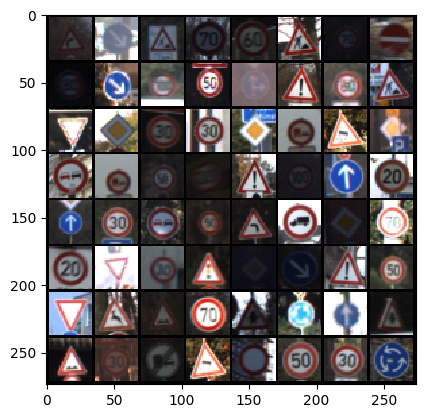

torch.Size([64, 3, 32, 32])


In [ ]:
# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(trainloader))
show(torchvision.utils.make_grid(sample))
plt.show()

print(sample.shape)  ## 64 c'est le batch
                        ## 1 c'est du gris --  3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)


## The optimisation

Use the function `train_model_multiclass` you have defined previously.

The main ingredient of the optimization is the definition of the learning rate and batch size, which set from the data loader tools.

The following code uses `torch.save` and `torch.load` to save and reload your networks during learning.

<font color='red'>Question</font>  Read and understand the code before running it.


train = 99.61%; val = 88.61%; loss = 1.462768e-02


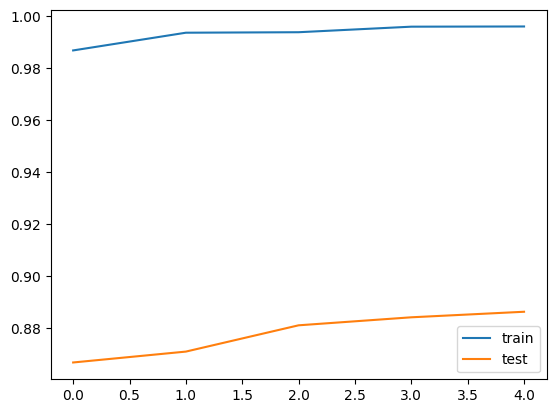

Adjusting learning rate of group 0 to 5.0000e-04.
Training complete in 14m 11s
Best val Acc: 0.886144
[[ 41   3   0 ...   0   0   0]
 [ 19 699  38 ...   0   0   0]
 [  0   5 682 ...   0   0   0]
 ...
 [  0   0   0 ...  75   0   0]
 [  0   0   0 ...   0  22   0]
 [  0   0   0 ...   0  22  88]]


In [ ]:
from torch.optim import lr_scheduler

# The name of the dataset
tag = "simpleCNN_gtsrb"
img_path = DATA_DIR

nlabel = 43

# create the network
net_gtsrb = SimpleCNN(n_in = 3, n_out=nlabel)

# Read the last learned network (if stored)
try:
  if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    print('Resume from last learning step')
    net_gtsrb = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
except:
  print('Learn from scratch')
  net_gtsrb = SimpleCNN(n_in = 3, n_out=nlabel)

net_gtsrb.to(device)

# Define optimization components (to be used in the learning function)
optimizer = torch.optim.Adam(net_gtsrb.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

# Learning
max_epoch = 5

learned_model, train_error, test_error, train_losses = \
train_model_multiclass(net_gtsrb, nlabel,
                        trainloader, testloader,
                        optimizer, scheduler,
                       num_epochs=max_epoch, display=True)

# Save last learned model
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

net_gtsrb = learned_model

# Evaluation
net_gtsrb.eval()

allpred = []
gt = []
with torch.no_grad():  ### no need to compute gradients
    for inputs, targets in testloader:
        inputs = inputs.to(device)
        outputs = net_gtsrb(inputs)
        _,pred = outputs.max(1)
        allpred += pred.cpu().numpy().tolist()
        gt += targets.cpu().numpy().tolist()

cm = confusion_matrix(allpred,gt,labels = list(range(nlabel)))
print(cm)

## Network analysis

The learned network can be analyzed to try to understand how it works.

The following code displays two things:
- The convolutional filters
- The outputs of the convolutional filters for a given sample.

<font color='red'>Question</font> Observe the results: what can be deduced from this visualization?

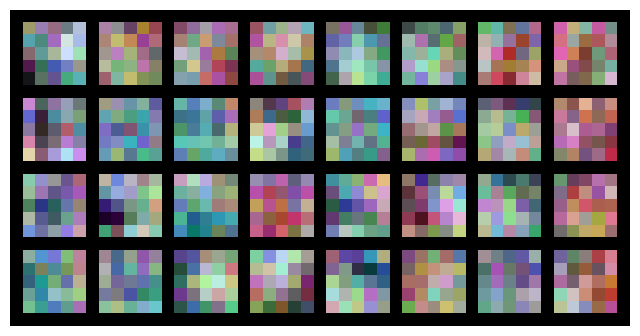

In [ ]:
# Visualization of the first convolution layer filters
from torchvision import utils
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

layer = 1
filter = net_gtsrb.conv1.weight.data.clone().cpu()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

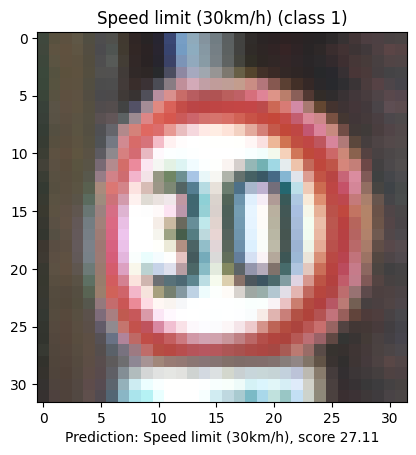

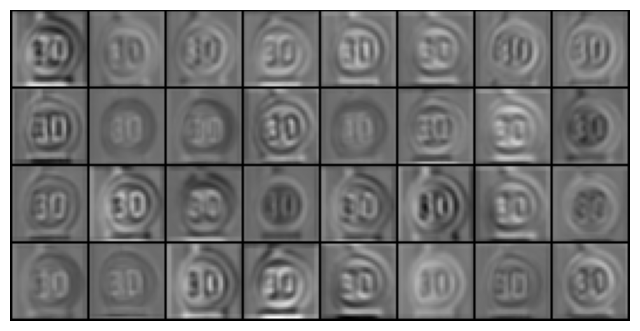

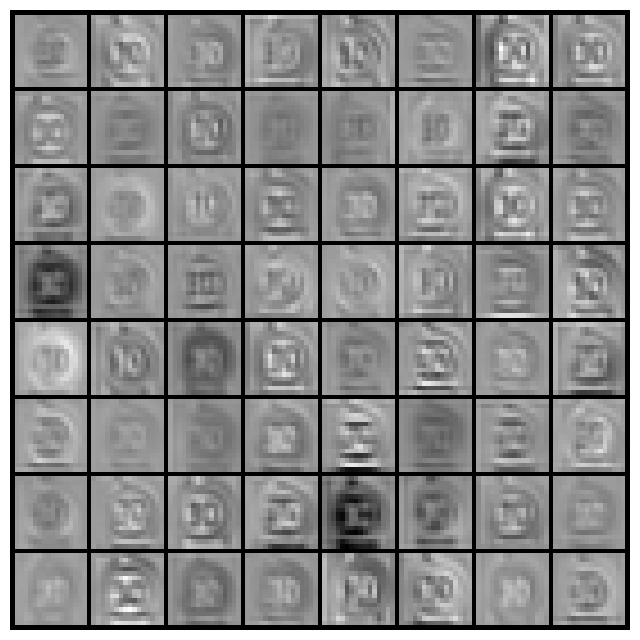

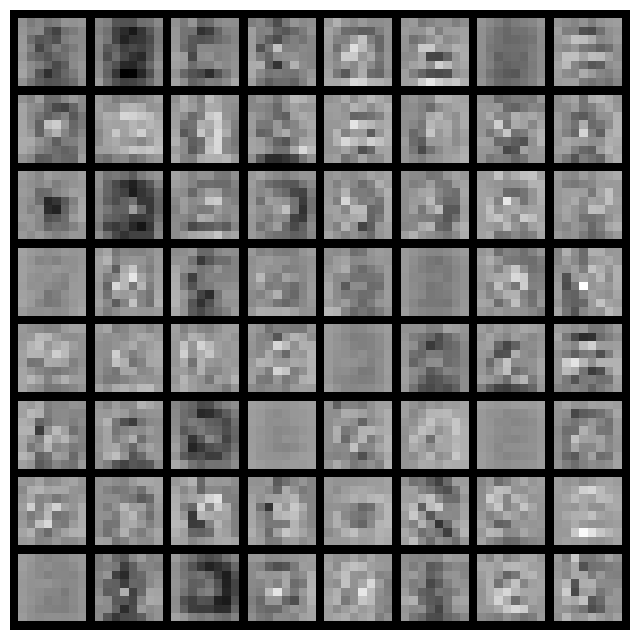

In [ ]:
# Little piece of code to export intermediate layer outputs
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = net_gtsrb
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

# Compute prediction for data isample
isample = 1

x = gtsrbtest[isample]
itarget = x[1]
with torch.no_grad():
  output = model(x[0].to(device))
lt,ipred = output.max(1)
ipred = ipred.item()
lt = lt.item()

# Show isample mage
plt.imshow(x[0].permute(1, 2, 0))
plt.title(f"{class_names[itarget]} (class {itarget})")
plt.xlabel(f"Prediction: {class_names[ipred]}, score {lt:.2f}")
plt.show()

# Show the intermediate convolutional layer outputs
conv1_output = activation['conv1']
conv1_output=conv1_output.unsqueeze(1)
visTensor(conv1_output.cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

conv2_output = activation['conv2']
conv2_output=conv2_output.unsqueeze(1)
visTensor(conv2_output.cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

conv3_output = activation['conv3']
conv3_output=conv3_output.unsqueeze(1)
visTensor(conv3_output.cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

# Transfer learning

We study in this part the capacity of a network to transfer to another task. More precisely we are going to see if features learned on some dataset can help learning on another dataset.

Here, we will study the transfer from GTRB (colorful road signs) to SVHN (colorful house numbers), expecting that the good features extracted from road signs are also good for colorful numbers.

## SVHN dataset

Run the following cell to upload the dataset and create the dataloaders.

100%|██████████| 64275384/64275384 [00:05<00:00, 12807542.70it/s]


100%|██████████| 182040794/182040794 [00:10<00:00, 17332810.91it/s]


torch.Size([64, 3, 32, 32])


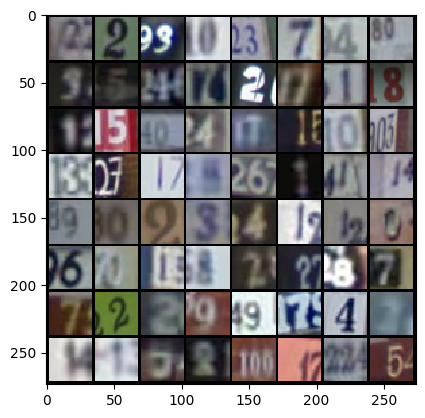

In [ ]:
transform_svhn = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

## Train and test are switched for faster computation
svhntrain = torchvision.datasets.SVHN("./svhn",split='test', transform=transform_svhn, download=True)
svhntest = torchvision.datasets.SVHN("./svhn",split='train', transform=transform_test, download=True)
trainloader = torch.utils.data.DataLoader(svhntrain, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(svhntest, batch_size=64, shuffle=False, num_workers=2)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Display few samples
sample,targets = next(iter(trainloader))
show(torchvision.utils.make_grid(sample))
print(sample.shape)  ## 64 c'est le batch
                        ## 1 c'est du gris -- sinon ce serait 3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)
plt.show()

## Learning strategy comparison

For transfer learning, we are going to load the network learned for GTSRB dataset, and change the last decision layer. We need to replace it by a layer with the good number of output neurons (here the $10$ digits).

For transfer learning there are two options:
- Learn only the last layer, assuming that the features are good
- Fine-tune the all network (features and last layer)

We want to compare the performance of these transfer learning strategies when using a single epoch for learning the new network.

<font color='red'>Question</font> Learn a new network starting from the network learned for the GTSRB dataset in the previous part updating the whole network.

<font color='red'>Question</font> Learn a new network starting from the network learned for the GTSRB dataset in the previous part updating only the last layer.

<font color='red'>Question</font> Learn a new network starting from scratch (random initilization).

<font color='red'>Question</font> Compare the performance of the three strategies.

You can make learning of each layer active or frozen by putting `requires_grad` to `True/False` for each parameter of `net.parameters()`.


train = 58.87%; val = 76.71%; loss = 1.246179e+00


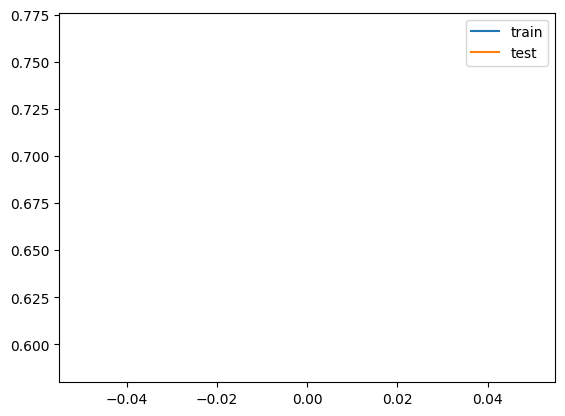

Adjusting learning rate of group 0 to 1.0000e-03.
Training complete in 3m 35s
Best val Acc: 0.767080
[[ 3555   160   156   216   134   132   414    82   297   381]
 [  741 12804   960   972  1053   344   466   863   549   437]
 [  143   193  8157   425   284   216   168   276   211   256]
 [   59   129   144  5285    81   648   165    52   262   270]
 [  101   197   202   141  5578   105   203    63   124   154]
 [   18    31    47   638    67  4694   356    39    86   156]
 [   92    59    52   135    76   272  2676    36   145    48]
 [   42   141   253   220    19   113    49  4080    31    57]
 [  129   107   285   404   117   280  1184    89  3260   457]
 [   68    40   329    61    49    78    46    15    80  2443]]


In [ ]:
from torch.optim import lr_scheduler

tag_pretrained = "simpleCNN_gtsrb"
nlabel = 10

img_path = DATA_DIR

for update in ['FT', 'LAST', 'SCRATCH']:
  ## Update the whole pre-trained network
  if update == 'FT':
    print(f'Fine tuning from pre-trained network {tag_pretrained}')
    tag = "simpleCNN_svhn_ft"

    # loads network learned from gtsrb
    net_svhn = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag_pretrained)))

    ########### Put your code here
    # Replace the last layer

  ## Update only the last layer
  elif update == 'LAST':
    print(f'Learn last layer from pre-trained network {tag_pretrained}')
    tag = "simpleCNN_svhn_last"

    # loads network learned from gtsrb
    net_svhn = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag_pretrained)))

    ######## Put your code here
    # only allows last layer to be learned

    # Replace the last layer

  ## Update from scratch
  else:
    print("Learning from scratch")
    # create the network
    tag = "simpleCNN_svhn_scratch"
    net_svhn = SimpleCNN(n_out=nlabel, n_in=3)

  net_svhn.to(device)

  # Define learning components (to be used in the learning function)
  optimizer = torch.optim.Adam(net_svhn.parameters(), lr=1e-3)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)

  # Learning
  max_epoch = 1

  learned_model, train_error, test_error, train_losses = \
  train_model_multiclass(net_svhn, nlabel,
                          trainloader, testloader,
                          optimizer, scheduler,
                          num_epochs=max_epoch, display=False)

  # Save last learned model
  torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))



In [ ]:
## Computes the performance of the three learning strategies
for tag in ['simpleCNN_svhn_ft', 'simpleCNN_svhn_scratch', 'simpleCNN_svhn_last']:
  net_svhn = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
  # Evaluation
  net_svhn.eval()

  cm = np.zeros((nlabel,nlabel),dtype=int)
  with torch.no_grad():  ### no need to compute gradients
      for inputs, targets in tqdm(testloader, ncols=80):
          inputs = inputs.to(device)
          outputs = net_svhn(inputs)
          _,pred = outputs.max(1)
          cm += confusion_matrix(pred.cpu().numpy(),targets.cpu().numpy(),labels = list(range(nlabel)))

  print(f"Accuracy of {tag} = {100*accuracy(cm):.1f}%")

100%|███████████████████████████████████████| 1145/1145 [01:56<00:00,  9.81it/s]


Accuracy of simpleCNN_svhn_ft = 79.7%


100%|███████████████████████████████████████| 1145/1145 [01:53<00:00, 10.10it/s]


Accuracy of simpleCNN_svhn_scratch = 76.7%


100%|███████████████████████████████████████| 1145/1145 [01:58<00:00,  9.66it/s]

Accuracy of simpleCNN_svhn_last = 71.7%
